In [8]:
#IMPORTING SETUP PACKAGES
import statsmodels.formula.api as smf
import pandas as pd

%matplotlib inline
import matplotlib.pyplot as plt
plt.style.use('seaborn-whitegrid')

from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

pd.set_option('display.max_rows', 500)

In [9]:
number_of_top_items = '5000'
plot_name = number_of_top_items[0] + 'k'

#print(plot_name)

df = pd.read_pickle('/Users/gabriele.sabato/PycharmProjects/raw_data/DataFrames/Top'+number_of_top_items+'_seller_YTD_group_by_item_visit_20210226.pickle')


In [10]:
print(df.item_code.nunique())

4488


In [11]:
print(df.dtypes)

min_date                  object
max_date                  object
item_code                 object
item_price               float64
delivery_weeks             int64
avg_sales                float64
avg_unique_views         float64
conv_rate                float64
bin                        int32
item_parent_item_code     object
item_main_category        object
item_sub_category_1       object
item_sub_category_2       object
log_price                float64
log_delivery_weeks       float64
log_sales                float64
log_avg_unique_views     float64
log_conv_rate            float64
dtype: object


In [12]:
def filter_df(DF = df,bins=6, avg_PDP = 19.):
    df_filt = DF[DF['bin'] > bins]
    df_items = df_filt.groupby('item_code').item_price.nunique() > 1
    df_filt  = df_filt.merge(df_items,on='item_code',how='inner')
    df_filt  = df_filt[df_filt['item_price_y']== True]
    #filter PDP
    #print(df_filt)
    df_filt = df_filt[df_filt['avg_unique_views'] > avg_PDP]
    #print(df_filt)
    return df_filt

In [13]:
df_filt = filter_df(df)


print(df_filt.item_code.nunique())

4181


In [7]:
#df_filt_zero_cr = df_filt[df_filt['conv_rate']==0.000001]
#df_filt_zero_cr.to_csv('./../raw_data/Excel_files/zero_sale_items.csv')

In [8]:
 #print(df_filt_zero_cr['item_code'].nunique())

In [14]:
#introducing the similarity score
sim_score = pd.read_parquet('/Users/gabriele.sabato/PycharmProjects/raw_data/recommendations_prod/part-00000-5f77392a-0bfa-4f0b-a4ae-d816ce2d71de-c000.snappy.parquet')

In [15]:
sim_score

,sku,recommended_sku,score
0,000000001000200072,000000001000200087,0.260000
1,000000001000200072,000000001000183538,0.216580
2,000000001000200072,000000001000142209,0.200000
3,000000001000200072,000000001000204906,0.190794
4,000000001000200072,000000001000183468,0.183980
...,...,...,...
3827600,000000001000064787,000000001000115010,0.203238
3827601,000000001000064787,000000001000112641,0.201339
3827602,000000001000064787,000000001000046204,0.200052
3827603,000000001000064787,000000001000114086,0.199867


In [16]:
# Filter table with only topX item_code

unique_item_codes = list(df_filt.item_code.unique())


sim_score_filt = sim_score[sim_score['sku'].isin(unique_item_codes)]

sim_score_filt

,sku,recommended_sku,score
780,000000001000135008,000000001000135012,0.881024
781,000000001000135008,000000001000121202,0.715546
782,000000001000135008,000000001000167468,0.633481
783,000000001000135008,000000001000166799,0.564164
784,000000001000135008,000000001000208980,0.544883
...,...,...,...
3827360,000000001000176744,000000001000171107,0.339302
3827361,000000001000176744,000000001000163202,0.335340
3827362,000000001000176744,000000001000163190,0.327887
3827363,000000001000176744,000000001000176438,0.324293


In [12]:
#Create a map with X subset for X linear fit:

def create_map(list_of_items = unique_item_codes , df=sim_score_filt, score_cut = 0.):
    map_of_items = {}
    for item_code in list_of_items:
        df_mod = df[df['sku'] == item_code]
        df_score_filt = df_mod[df_mod['score'] > score_cut]
        final_set_sku = list(df_score_filt.recommended_sku)
        final_set_sku.insert(0,item_code)
        map_of_items[item_code] = final_set_sku
    #print(map_of_items)
    return map_of_items


In [13]:
sim_score_bin = [0.16]#0.3,0.4,0.5,0.6,0.7,0.8,0.9]




In [14]:
map_of_map_of_items = {}
for sim_score_i in sim_score_bin:
    Map_of_Items = create_map(score_cut = sim_score_i)
    map_of_map_of_items[str(sim_score_i)] = Map_of_Items
#print(map_of_map_of_items)

In [15]:
#load greater dataset 
largest_dataset = '/Users/gabriele.sabato/PycharmProjects/raw_data/DataFrames/All_catalogue_seller_YTD_group_by_item_visit_20210226.pickle'

#df_k = pd.read_pickle(dataset10k)
df_k = pd.read_pickle(largest_dataset)

In [16]:
PDP_bin = [19]#,30,40,50]

In [17]:
df_PDP_bin_filt = {}
for PDP_view in PDP_bin:
    df_k_filt = filter_df(df_k, avg_PDP= PDP_view)
    df_PDP_bin_filt[PDP_view] = df_k_filt
    #print(df_k_filt)

#print(df_PDP_bin_filt)


In [19]:
#df_one = df_PDP_bin_filt[19]
#df_full_zero_sales = df_one[df_one['conv_rate']==0.000001]

In [20]:
#print(df_full_zero_sales.item_code.nunique())
#df_full_zero_sales.head(100)
#df_full_zero_sales.to_csv('./../raw_data/Excel_files/zero_sale_items_whole_catalogue.csv')

In [21]:
def create_map_of_dataframes(items_map = Map_of_Items,df=df_filt):
    map_of_df = {}
    for key in items_map.keys():
        items  = items_map[key]
        #print(f'Item_code = {key}')
        
        df_mod = df[df['item_code'].isin(items)]
        #
        #print(f'Number of items per cluster {df_mod.item_code.nunique()}')
        map_of_df[key]= df_mod
    return map_of_df



In [23]:
import numpy as np
def run_model(item_code, df, map_results):
    #print('\n')
    wls_cr_with_fe = smf.wls("conv_rate ~ log_price + log_delivery_weeks + C(item_code)", df, weights=df['bin']).fit()

    beta_log_price, beta_std_err_log_price = wls_cr_with_fe.params[-2].round(4),wls_cr_with_fe.bse[-2].round(4)
    beta_log_del, beta_std_err_log_del = wls_cr_with_fe.params[-1].round(4),wls_cr_with_fe.bse[-1].round(4)
    Result_log_price = 'Log_price  = ' + str(beta_log_price) + ' ± ' + str(beta_std_err_log_price)
    Result_log_del = 'Log_del_week = ' + str(beta_log_del) + ' ± ' + str(beta_std_err_log_del)
    flag_stat_ok = False
    if beta_log_price != 0 :
        flag_stat_ok = np.fabs((3*beta_std_err_log_price)/beta_log_price) < 1.
    #flag_stat_ok = fabs(beta_std_err_log_price/beta_log_price)
    else:
        print(f'Running model for the item = {item_code}, beta_log_price is null')
        #print(wls_cr_with_fe.summary())

    if flag_stat_ok:
        #print(f'Enough statistics for the item = {item_code}')
        #print(Result_log_price)
        #print(Result_log_del)
        map_results[item_code] = [beta_log_price, beta_std_err_log_price, beta_log_del,beta_std_err_log_del, df.item_code.nunique(), True]
        #print(map_results[item_code])
        return True
    else:
        #print(f'Not enough statistics for the item = {item_code}')
        #print(Result_log_price)
        #print(Result_log_del)
        map_results[item_code] = [beta_log_price, beta_std_err_log_price, beta_log_del,beta_std_err_log_del, df.item_code.nunique(), False]
        #print(map_results[item_code])
        return False


In [24]:
df_result = pd.DataFrame()

map_of_maps_of_df = {}
#print('Cut on PDP, sim_score, result = ')
for PDP_cut in df_PDP_bin_filt.keys():
    for score_cut in  map_of_map_of_items.keys():
        map_of_dfs = create_map_of_dataframes(map_of_map_of_items[score_cut],df=df_PDP_bin_filt[PDP_cut])
        map_of_maps_of_df[PDP_cut] = map_of_dfs
        print(f'Number of items passing the PE cut {len(map_of_dfs)}')

        map_result = {}

        #print("Model used: conv_rate ~ log_price + log_delivery_weeks + C(item_code)\n")
        map_items_stat = {}
        for key in map_of_dfs.keys():
            #map_of_dfs[key].head()
            map_items_stat[key] = run_model(key, map_of_dfs[key], map_result)

            #print(map_result)

        items_stat_series = pd.Series(map_items_stat)
        #print(map_items_stat)
        #print(items_stat_series)


        
        x,y, y_err, rel_err = {'True':[],'False':[]},{'True':[],'False':[]},{'True':[],'False':[]},{'True':[],'False':[]}
        for i_code,flag in items_stat_series.items():
        #flag=T
            if flag == True:

                y['True'].append(map_result[i_code][0])
                y_err['True'].append(map_result[i_code][1])
                x['True'].append(map_result[i_code][-2])
                #print('True',map_result[i_code][0],map_result[i_code][1])
                rel_err['True'].append(abs(map_result[i_code][1]/map_result[i_code][0]))


            else:
                y['False'].append(map_result[i_code][0])
                y_err['False'].append(map_result[i_code][1])
                x['False'].append(map_result[i_code][-2])
                #print('False',map_result[i_code][0],map_result[i_code][1])
                rel_err['False'].append(abs(map_result[i_code][1]/map_result[i_code][0]))

                continue
        #print(f'{PDP_cut},{score_cut} , {len(x)}')
        df_result = pd.DataFrame.from_dict(map_result, orient='index', columns = ['PE', 'PE_err', 'log_del_week', 'log_del_week_err', 'Cluster_size', 'has_enough_stat'])
        #print (df_result.head(100))


Number of items passing the PE cut 4181
Running model for the item = 000000001000085420, beta_log_price is null
Running model for the item = 000000001000020148, beta_log_price is null
Running model for the item = 000000001000053664, beta_log_price is null
Running model for the item = 000000001000030828, beta_log_price is null
Running model for the item = 000000001000133170, beta_log_price is null
Running model for the item = 000000001000011161, beta_log_price is null
Running model for the item = 000000001000175842, beta_log_price is null


/Users/gabriele.sabato/opt/anaconda3/lib/python3.8/site-packages/statsmodels/regression/linear_model.py:1650: RuntimeWarning: divide by zero encountered in double_scalars
  return np.dot(wresid, wresid) / self.df_resid
/Users/gabriele.sabato/opt/anaconda3/lib/python3.8/site-packages/statsmodels/regression/linear_model.py:1650: RuntimeWarning: divide by zero encountered in double_scalars
  return np.dot(wresid, wresid) / self.df_resid
/Users/gabriele.sabato/opt/anaconda3/lib/python3.8/site-packages/statsmodels/regression/linear_model.py:1650: RuntimeWarning: invalid value encountered in double_scalars
  return np.dot(wresid, wresid) / self.df_resid
/Users/gabriele.sabato/opt/anaconda3/lib/python3.8/site-packages/statsmodels/regression/linear_model.py:1650: RuntimeWarning: divide by zero encountered in double_scalars
  return np.dot(wresid, wresid) / self.df_resid
/Users/gabriele.sabato/opt/anaconda3/lib/python3.8/site-packages/statsmodels/regression/linear_model.py:1650: RuntimeWarning:

In [25]:
#map_of_dfs['000000001000081137'].head(1000)


In [25]:
df_result_true = df_result[df_result['has_enough_stat']==True]
print(len(df_result_true.index))
#print(df_result.head(100))

df_filt_result_high = df_result_true[df_result_true['PE'] < -0.05]

#print(df_filt_result_high.head(100))

items_to_test = list(df_filt_result_high.index.values)
#print(items_to_test)
print(len(items_to_test))
#for item in items_to_test:
    #print(map_of_dfs[str(item)])
    #df_of_df = pd.DataFrame().from_dict(map_of_dfs[str(item)], orient = 'columns')
    #print(df_of_df)#
#    break

1907
128


In [26]:
df_filt_result_low = df_result_true[df_result_true['PE'] > -0.02]
#print(df_filt_result_low.head(100))
items_to_test_low = list(df_filt_result_low.index.values)
#print(items_to_test_low)
print(len(items_to_test_low))

987


In [27]:
df_result_false = df_result[df_result['has_enough_stat']==False]
#print(df_result_false.head(100))
items_false = list(df_result_false.index.values)
#print(items_false)
print(len(items_false))

2274


In [29]:
import matplotlib.lines as mlines

def create_legend(flag={'blue' : 'Items with sign stat', 'red': 'Items with not sign stat'}):
    good_stat_leg = []
    for key in flag.keys():
        good_stat_leg.append( mlines.Line2D([], [], color=key, marker = 'o',
                          markersize=6, label=flag[key]))
        
    plt.legend(handles=good_stat_leg)

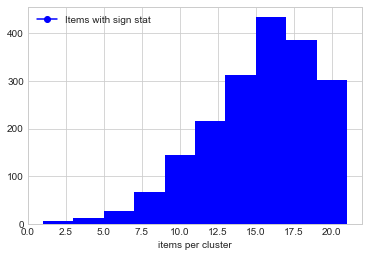

In [30]:
plt.hist(x['True'], color= 'blue')
plt.xlabel('items per cluster')
create_legend({'blue':'Items with sign stat'})
plt.savefig('./plots/items_per_cluster_good_top'+plot_name+'_20210226.png')
plt.show()

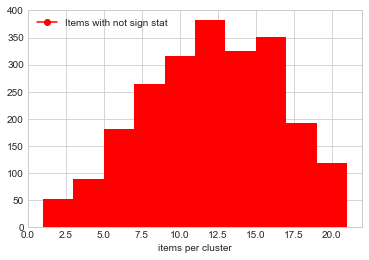

In [31]:
plt.hist(x['False'],color ='red')
plt.xlabel('items per cluster')
create_legend({'red':'Items with not sign stat'})
plt.savefig('./plots/items_per_cluster_bad_top'+plot_name+'_20210226.png')
plt.show()

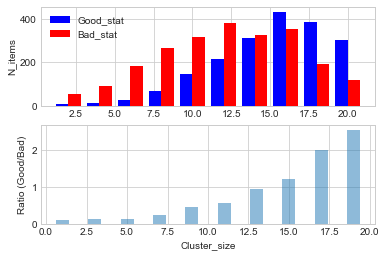

In [32]:
fig, (ax1, ax2) = plt.subplots(nrows=2)

ns, bins, patches = ax1.hist([x['True'],x['False']],
                      label=['Good_stat','Bad_stat'],
                      color = ['blue','red']
                      )

ax1.legend()

ax2.bar(bins[:-1],     # this is what makes it comparable
            ns[0] / ns[1], # maybe check for div-by-zero!
        alpha=0.5)

ax1.set_ylabel('N_items')
ax2.set_ylabel('Ratio (Good/Bad)')
ax2.set_xlabel('Cluster_size')


plt.savefig('./plots/ratio_cluster_size_bad_top'+plot_name+'_20210226.png')



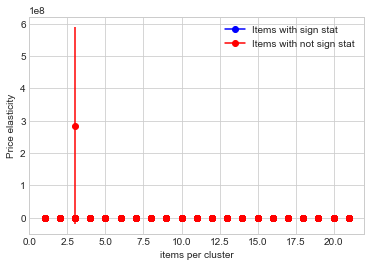

In [33]:
plt.errorbar(x['True'], y['True'], yerr=y_err['True'],fmt='o', c='blue')
plt.errorbar(x['False'], y['False'], yerr=y_err['False'],fmt='o',c='red')
plt.xlabel('items per cluster')
plt.ylabel('Price elasticity')


create_legend()
plt.savefig('./plots/PE_vs_items_per_cluster_top'+plot_name+'_20210226.png')
plt.show()



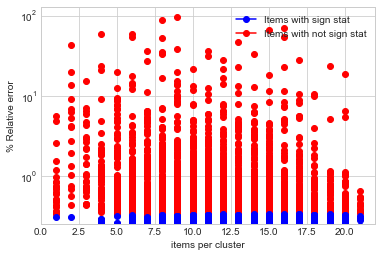

In [34]:
plt.scatter(x['False'],rel_err['False'],c='red')
plt.scatter(x['True'],rel_err['True'],c='blue')
plt.xlabel('items per cluster')
plt.ylabel('% Relative error')
plt.yscale('log')
create_legend()
plt.savefig('./plots/Relative_error_vs_items_per_cluster_top'+plot_name+'_20210226.png')
plt.show()

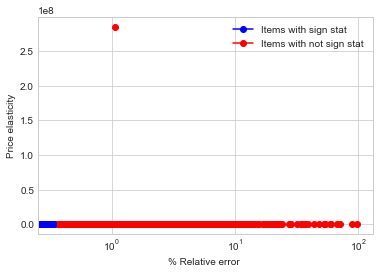

In [35]:
plt.scatter(rel_err['False'],y['False'],c='red')
plt.scatter(rel_err['True'],y['True'],c='blue')
plt.ylabel('Price elasticity')
plt.xlabel('% Relative error ')
plt.xscale('log')
#plt.yscale('log')
create_legend()
plt.savefig('./plots/Relative_error_vs_PE_top'+plot_name+'_20210226.png')
plt.show()



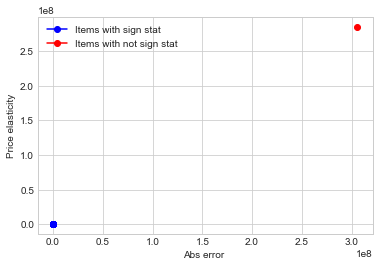

In [36]:
plt.scatter(y_err['False'],y['False'],c='red')
plt.scatter(y_err['True'],y['True'],c='blue')
plt.ylabel('Price elasticity')
plt.xlabel('Abs error ')
#plt.xscale('log')
create_legend()
plt.savefig('./plots/Abs_error_vs_PE_top'+plot_name+'_20210226.png')
plt.show()



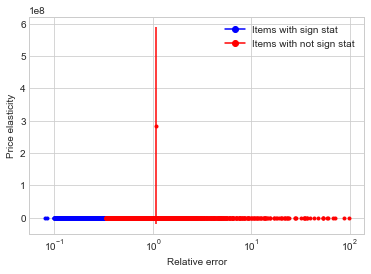

In [37]:
plt.errorbar(rel_err['True'], y['True'], yerr=y_err['True'],fmt='.', c='blue')
plt.errorbar(rel_err['False'], y['False'], yerr=y_err['False'],fmt='.',c='red')
plt.xlabel('Relative error')
plt.ylabel('Price elasticity')
plt.xscale('log')

create_legend()
plt.savefig('./plots/Rel_err_vs_PE_plus_abs_err_top'+plot_name+'_20210226.png')
plt.show()

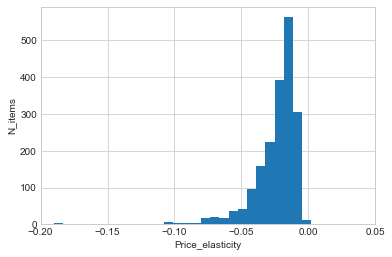

In [38]:
plt.xlim(-0.2,+0.05)
plt.hist(y['True'], bins=50)
plt.xlabel('Price_elasticity')
plt.ylabel('N_items')

plt.savefig('./plots/PE_histo_top'+plot_name+'.png')
plt.show()


In [39]:
import statistics
print(statistics.median(y['True']))


-0.0194


In [40]:
def split(a, n):
    k, m = divmod(len(a), n)
    return (a[i * k + min(i, m):(i + 1) * k + min(i + 1, m)] for i in range(n))

y['True'].sort()
three_list = list(split(y['True'],3))


print(three_list[0][-1],three_list[1][-1] )

-0.0252 -0.0152


In [41]:
df_result_true_high = df_result_true[df_result_true['PE'] <= three_list[0][-1] ]
print(len(df_result_true_high.index))
df_result_true_medium = df_result_true[ (df_result_true['PE'] > three_list[0][-1] ) & ( df_result_true['PE'] <= three_list[1][-1])]
print(len(df_result_true_medium.index))
df_result_true_low = df_result_true[df_result_true['PE'] > three_list[1][-1] ]
print(len(df_result_true_low.index))

637
637
633


In [42]:
list_high   = list(df_result_true_high.index)
list_medium = list(df_result_true_medium.index)
list_low    = list(df_result_true_low.index)
#print(df_result_true_high.index)

In [43]:
df_result_true_high.to_csv('./pickle_files/Top'+plot_name+'_high_el_20210226.csv')
df_result_true_medium.to_csv('./pickle_files/Top'+plot_name+'_medium_el_20210226.csv')
df_result_true_low.to_csv('./pickle_files/Top'+plot_name+'_low_el_20210226.csv')

In [44]:
import pickle
def save_obj(obj, name ):
    with open('pickle_files/'+ name + '.pkl', 'wb') as f:
        pickle.dump(obj, f, pickle.HIGHEST_PROTOCOL)


In [45]:
#AVAILABLE ITEMS

df_reach = pd.read_csv('../raw_data/stock_av/item_code_stock_reach.csv',dtype = {'item_code':str})

#df_reach= df_reach.astype({'item_code': 'string'})
print(df_reach.dtypes)
avl_item = list(df_reach.item_code.values)
print(avl_item[0])

item_code                object
available_stock           int64
avg_sales_forecasted    float64
reach                   float64
dtype: object
000000001000208731


In [46]:
df_result_true = df_result_true[['PE','PE_err']]
#print(df_result_true.head())
#print(df_result_true.columns)

In [47]:
#df_result_true = df_result_true.rename(column_index={'':'item_code'})
print(df_result_true.head(1000))
print(df_result_true.dtypes)

                        PE  PE_err
000000001000012530 -0.0187  0.0059
000000001000021922 -0.0194  0.0025
000000001000005727 -0.0246  0.0044
000000001000007327 -0.0229  0.0049
000000001000050787 -0.0284  0.0087
...                    ...     ...
000000001000053282 -0.0138  0.0028
000000001000007033 -0.0054  0.0016
000000001000007443 -0.0217  0.0054
000000001000008013 -0.0142  0.0038
000000001000008067 -0.0294  0.0048

[1000 rows x 2 columns]
PE        float64
PE_err    float64
dtype: object


In [48]:
print(avl_item)

['000000001000208731', '000000001000174885', '000000001000174813', '000000001000224524', '000000001000075000', '000000001000174978', '000000001000092143', '000000001000075003', '000000001000208732', '000000001000090822', '000000001000208734', '000000001000119632', '000000001000215112', '000000001000164750', '000000001000208730', '000000001000174884', '000000001000208735', '000000001000101404', '000000001000187774', '000000001000075002', '000000001000074998', '000000001000224526', '000000001000092141', '000000001000090865', '000000001000174806', '000000001000072366', '000000001000174822', '000000001000174887', '000000001000174975', '000000001000174818', '000000001000215101', '000000001000208243', '000000001000092145', '000000001000208721', '000000001000215100', '000000001000092144', '000000001000174833', '000000001000151818', '000000001000187768', '000000001000135006', '000000001000021947', '000000001000191290', '000000001000125854', '000000001000231374', '000000001000104693', '00000000

In [49]:
df_stock_filt=df_result_true[df_result_true.index.isin(avl_item)]
print(df_stock_filt.head())

print(len(df_stock_filt.index))

                        PE  PE_err
000000001000012530 -0.0187  0.0059
000000001000005727 -0.0246  0.0044
000000001000007327 -0.0229  0.0049
000000001000117179 -0.0242  0.0072
000000001000164660 -0.0030  0.0007
610


In [50]:
#PREPARE THE CONVERSION RATE FILE
final_items = list(df_stock_filt.index.values)
print(len(final_items))



610


In [51]:
print(df_filt.head(10))

      min_date    max_date           item_code  item_price_x  delivery_weeks  \
0   2020-01-01  2020-05-23  000000001000012530         99.99               1   
2   2020-05-31  2020-06-26  000000001000012530         99.99               1   
5   2020-08-06  2020-08-20  000000001000012530         99.99               1   
7   2020-09-16  2020-10-31  000000001000012530         99.99               1   
8   2020-11-01  2020-11-07  000000001000012530         99.99               1   
9   2020-11-10  2020-11-22  000000001000012530         99.99               1   
11  2020-12-08  2020-12-27  000000001000012530         99.99               1   
12  2021-01-05  2021-02-13  000000001000012530         99.99               1   
13  2020-01-01  2020-03-13  000000001000021922        129.99               2   
14  2020-04-15  2020-04-21  000000001000021922        119.99               4   

    avg_sales  avg_unique_views  conv_rate  bin item_parent_item_code  \
0    0.520833         35.743056   0.014573  14

In [52]:
df_final = df_filt[['item_code','max_date','item_price_x','conv_rate','avg_sales', 'avg_unique_views']]

print(df_final.head())

            item_code    max_date  item_price_x  conv_rate  avg_sales  \
0  000000001000012530  2020-05-23         99.99   0.014573   0.520833   
2  000000001000012530  2020-06-26         99.99   0.008923   0.444444   
5  000000001000012530  2020-08-20         99.99   0.026937   0.533333   
7  000000001000012530  2020-10-31         99.99   0.013050   0.478261   
8  000000001000012530  2020-11-07         99.99   0.021128   1.714286   

   avg_unique_views  
0         35.743056  
2         49.814815  
5         19.800000  
7         36.652174  
8         81.142857  


In [53]:
df_final= df_final[df_filt['item_code'].isin(final_items)]

In [54]:
print(df_final.head())

            item_code    max_date  item_price_x  conv_rate  avg_sales  \
0  000000001000012530  2020-05-23         99.99   0.014573   0.520833   
2  000000001000012530  2020-06-26         99.99   0.008923   0.444444   
5  000000001000012530  2020-08-20         99.99   0.026937   0.533333   
7  000000001000012530  2020-10-31         99.99   0.013050   0.478261   
8  000000001000012530  2020-11-07         99.99   0.021128   1.714286   

   avg_unique_views  
0         35.743056  
2         49.814815  
5         19.800000  
7         36.652174  
8         81.142857  


In [1]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import *
spark = SparkSession.builder.master('local').config('spark.driver.memory', '8g').appName('Ready_for_analysis').getOrCreate()

Exception: Java gateway process exited before sending its port number

In [8]:
! export JAVA_HOME= "/Library/Java/JavaVirtualMachines/jdk1.8.0_291.jdk/Contents/Home"

/bin/bash: line 0: export: `/Library/Java/JavaVirtualMachines/jdk1.8.0_291.jdk/Contents/Home': not a valid identifier


In [9]:
! echo $JAVA_HOME

/Library/Internet Plug-Ins/JavaAppletPlugin.plugin/Contents/Home


In [56]:
df_to_spark = df_final.groupby(['item_code']).nth(-1)
df_to_spark.reset_index(level=0,inplace=True)
df_to_spark.rename(columns={'index':'item_code'}, inplace=True)
spark_check = spark.createDataFrame(df_to_spark)


In [57]:
spark_check.show()

+------------------+----------+------------+--------------------+------------------+------------------+
|         item_code|  max_date|item_price_x|           conv_rate|         avg_sales|  avg_unique_views|
+------------------+----------+------------+--------------------+------------------+------------------+
|000000001000000145|2020-06-04|      169.99|0.019559359621451104|1.3880597014925373| 70.97014925373135|
|000000001000005221|2021-02-25|      229.99|0.009919319719953325|0.3090909090909091|31.163636363636364|
|000000001000005222|2021-02-25|      179.99|0.030304030303030305|0.8571428571428571|28.285714285714285|
|000000001000005726|2021-02-25|       99.99|0.017899832684824903|               2.0|111.73913043478261|
|000000001000005727|2021-02-25|       99.99| 0.01875693542260209|3.4347826086956523| 183.1304347826087|
|000000001000005729|2021-02-15|       99.99|0.004556808656036446|0.3076923076923077| 67.53846153846153|
|000000001000005744|2021-02-25|       69.99|0.022458067371202116

In [58]:
spark_df = spark.createDataFrame(df_final)

In [59]:
spark_df.createOrReplaceTempView('Final_table')


In [60]:
spark_last_price = spark.sql("""with max_price as (SELECT item_code, ROW_NUMBER() over (PARTITION BY item_code ORDER BY max_date DESC) as rn, item_price_x, max_date
                            from Final_table)
                            SELECT item_code, item_price_x, max_date
                            from max_price
                            where rn=1
                            """)
spark_last_price.show()

+------------------+------------+----------+
|         item_code|item_price_x|  max_date|
+------------------+------------+----------+
|000000001000012530|       99.99|2021-02-13|
|000000001000005727|       99.99|2021-02-25|
|000000001000007327|      209.99|2021-02-25|
|000000001000114877|      119.99|2021-02-25|
|000000001000117179|      319.99|2021-02-25|
|000000001000164660|      729.99|2021-02-25|
|000000001000176734|      159.99|2021-02-08|
|000000001000008470|       89.99|2021-02-13|
|000000001000129145|      179.99|2021-02-22|
|000000001000012817|      289.99|2021-02-25|
|000000001000022615|       34.99|2021-02-25|
|000000001000104023|      399.99|2021-02-08|
|000000001000156992|      139.99|2021-02-25|
|000000001000182807|      969.99|2021-02-25|
|000000001000008474|      139.99|2021-02-25|
|000000001000008491|      139.99|2021-02-25|
|000000001000022564|      164.99|2020-10-20|
|000000001000174114|      114.99|2021-02-25|
|000000001000061845|      399.99|2021-02-25|
|000000001

In [61]:
spark_last_price.createOrReplaceTempView('last_price')


In [62]:
spark_check.createOrReplaceTempView('check_last_price')


In [63]:
disjoint_spark = spark.sql("""SELECT *
                                from check_last_price as clp
                                inner join last_price as lp on lp.item_code = clp.item_code and lp.item_price_x!= clp.item_price_x  """)

disjoint_spark.show()

+---------+--------+------------+---------+---------+----------------+---------+------------+--------+
|item_code|max_date|item_price_x|conv_rate|avg_sales|avg_unique_views|item_code|item_price_x|max_date|
+---------+--------+------------+---------+---------+----------------+---------+------------+--------+
+---------+--------+------------+---------+---------+----------------+---------+------------+--------+



In [64]:
spark_filter = spark.sql("""SELECT ft.item_code, AVG(ft.conv_rate) as avg_conv_rate, MAX(ft.item_price_x) as last_price, MAX(ft.max_date) as last_date, AVG(avg_unique_views) as avg_unique_views
                            from Final_table as ft
                            inner join last_price as lp on lp.item_code = ft.item_code and lp.item_price_x = ft.item_price_x
                            GROUP BY ft.item_code
                            """)
spark_filter.show()

+------------------+--------------------+----------+----------+------------------+
|         item_code|       avg_conv_rate|last_price| last_date|  avg_unique_views|
+------------------+--------------------+----------+----------+------------------+
|000000001000012530|0.016219531350040728|     99.99|2021-02-13| 66.08138736263736|
|000000001000114877| 0.01852575581003705|    119.99|2021-02-25|269.90909090909093|
|000000001000117179|0.002919049275148...|    319.99|2021-02-25| 104.0336956521739|
|000000001000176734|0.007735806629834255|    159.99|2021-02-08|100.55555555555556|
|000000001000164660|3.251199630981886...|    729.99|2021-02-25| 259.3716194912041|
|000000001000007327| 0.01119257340355497|    209.99|2021-02-25|46.738461538461536|
|000000001000005727|0.017079081037479026|     99.99|2021-02-25| 170.0990338164251|
|000000001000008470|0.020171674941815362|     89.99|2021-02-13|189.55882352941177|
|000000001000129145|0.005458853244390...|    179.99|2021-02-22| 86.78947368421052|
|000

In [65]:
spark_filter.createOrReplaceTempView('Final_table_filt')



In [66]:

df_stock_filt.reset_index(level=0,inplace=True)



In [67]:
df_stock_filt.rename(columns={'index':'item_code'}, inplace=True)

/Users/gabriele.sabato/anaconda3/envs/pythonProject/lib/python3.8/site-packages/pandas/core/frame.py:4290: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().rename(


In [68]:
print(df_stock_filt.head())

            item_code      PE  PE_err
0  000000001000012530 -0.0187  0.0059
1  000000001000005727 -0.0246  0.0044
2  000000001000007327 -0.0229  0.0049
3  000000001000117179 -0.0242  0.0072
4  000000001000164660 -0.0030  0.0007


In [69]:
spark_PE_df = spark.createDataFrame(df_stock_filt )

In [70]:
spark_PE_df.show()

+------------------+-------+------+
|         item_code|     PE|PE_err|
+------------------+-------+------+
|000000001000012530|-0.0187|0.0059|
|000000001000005727|-0.0246|0.0044|
|000000001000007327|-0.0229|0.0049|
|000000001000117179|-0.0242|0.0072|
|000000001000164660| -0.003|7.0E-4|
|000000001000176734|-0.0149| 0.003|
|000000001000008470|-0.0366|0.0073|
|000000001000012817|-0.0128|0.0025|
|000000001000022615|-0.0625|0.0131|
|000000001000156992|-0.0089|0.0024|
|000000001000008474|-0.0312|  0.01|
|000000001000008491|-0.0337|0.0059|
|000000001000061845|-0.0187|0.0049|
|000000001000065698|-0.0219|0.0059|
|000000001000110285|-0.0307|0.0101|
|000000001000153506|-0.0189|0.0048|
|000000001000054183|-0.0109|0.0022|
|000000001000173830|-0.0163|0.0046|
|000000001000184194|-0.0321| 0.009|
|000000001000092325|-0.0102|0.0032|
+------------------+-------+------+
only showing top 20 rows



In [71]:
spark_PE_df.createOrReplaceTempView('final_PE')

In [72]:
spark_final = spark.sql("""SELECT ftf.*, fpe.PE, fpe.PE_err
                            from Final_table_filt as ftf
                            INNER JOIN final_PE as fpe on fpe.item_code = ftf.item_code""")
spark_final.show()
spark_final.createOrReplaceTempView('spark_final_tmp')

+------------------+--------------------+----------+----------+------------------+-------+------+
|         item_code|       avg_conv_rate|last_price| last_date|  avg_unique_views|     PE|PE_err|
+------------------+--------------------+----------+----------+------------------+-------+------+
|000000001000012530|0.016219531350040728|     99.99|2021-02-13| 66.08138736263736|-0.0187|0.0059|
|000000001000005727|0.017079081037479026|     99.99|2021-02-25| 170.0990338164251|-0.0246|0.0044|
|000000001000007327| 0.01119257340355497|    209.99|2021-02-25|46.738461538461536|-0.0229|0.0049|
|000000001000114877| 0.01852575581003705|    119.99|2021-02-25|269.90909090909093|-0.0155|0.0029|
|000000001000117179|0.002919049275148...|    319.99|2021-02-25| 104.0336956521739|-0.0242|0.0072|
|000000001000164660|3.251199630981886...|    729.99|2021-02-25| 259.3716194912041| -0.003|7.0E-4|
|000000001000176734|0.007735806629834255|    159.99|2021-02-08|100.55555555555556|-0.0149| 0.003|
|000000001000008470|

In [73]:
spark.sql("""SELECT COUNT(DISTINCT item_code)
from spark_final_tmp""").show()


+-------------------------+
|count(DISTINCT item_code)|
+-------------------------+
|                      610|
+-------------------------+



In [74]:
spark.sql("""SELECT COUNT(item_code)
from spark_final_tmp""").show()



+----------------+
|count(item_code)|
+----------------+
|             610|
+----------------+



In [75]:
#Introduce d_item table
sp_df_item = spark.read.parquet(
    '/Users/gabriele.sabato/PycharmProjects/raw_data/redshift_tables/d_item/*.parquet',
    header=True)
sp_df_item.show()

+---------------+------------------+---------------------+-------------+----------------+----------+-------------+-----------+----------+-----------+--------------+-------------+--------------------+----------------------+--------------------+------------------+--------------------+------------------+-------------------+-------------------+---------+--------------------------------+---------------------------------------------+-----------------------+---------------------+------------------------+--------------------------+------------------------+--------------------+-----------+-------------------+------------------+-------------------+----------------------------+---------------+-----------------------+-----------------------+----------------------+------------------------------------+-------------------------------------------+-------------------------------------------------+--------------------------------------------------------+------------------------+---------------------+---

In [76]:
#Introduce PC2 table
sp_df_pc2 = spark.read.parquet(
    '/Users/gabriele.sabato/PycharmProjects/raw_data/redshift_tables/f_item_status_last/*.parquet',
    header=True)
sp_df_pc2.show()

+-----------+---------+----------------+-----------------------+--------------------------+--------------------------+--------------------------+--------------------------------+---------------------------------+---------------------------------------+
|  item_skey|shop_skey|item_status_skey|item_status_weekly_skey|item_pc1_costs_before_cogs|item_pc2_costs_before_cogs|group_pc2_margin_simulated|group_pc2_margin_ratio_simulated|group_pc2_margin_simulated_pocket|group_pc2_margin_ratio_simulated_pocket|
+-----------+---------+----------------+-----------------------+--------------------------+--------------------------+--------------------------+--------------------------------+---------------------------------+---------------------------------------+
| 4184608796|        1|               4|                      4|                   674.169|                   800.340|                      null|                            null|                             null|                             

In [77]:
sp_df_item.createOrReplaceTempView('d_item_tmp')
sp_df_pc2.createOrReplaceTempView('d_item_pc2')

In [78]:
pc2_table = spark.sql(""" WITH pc2_avg as (
                            SELECT item_skey,
                            item_pc2_costs_before_cogs as pc2
                            from d_item_pc2
                            where shop_skey = 1)
                            SELECT pc.item_skey,di.item_code, pc.pc2
                            from d_item_tmp as di
                            INNER JOIN pc2_avg as pc on pc.item_skey = di.item_skey
                            where di.item_code like '0%'
                            """)
pc2_table.show()


+------------+------------------+-------+
|   item_skey|         item_code|    pc2|
+------------+------------------+-------+
|  4184608796|000000001000157424|800.340|
| 43499951512|000000001000114687|342.220|
| 63209271384|000000001000193143|113.050|
| 64339265064|000000001000038173|307.399|
| 67389826157|000000001000232523| 13.970|
|178212850851|000000001000220797|111.220|
|251843179141|000000001000125573|510.380|
|321153977917|000000001000151885|532.309|
|324513273733|000000001000176129| 29.980|
|360959333013|000000001000222621| 73.629|
|391563460770|000000001000061915|212.229|
|414751597565|000000001000024545| 65.040|
|451907443162|000000001000103142|285.139|
|453294840650|000000001000047001|146.060|
|462665822707|000000001000112387| 46.340|
|464745354617|000000001000020098|346.680|
|518044503882|000000001000016906|619.179|
|526193144479|000000001000010513| 33.609|
|551043742079|000000001000219102| 13.289|
|556925096750|000000001000187198| 15.800|
+------------+------------------+-

In [79]:
pc2_table.createOrReplaceTempView('pc2_table')

In [80]:
spark.sql("""SELECT COUNT(DISTINCT item_skey) FROM pc2_table""").show()
spark.sql("""SELECT COUNT(item_skey) FROM pc2_table""").show()

+-------------------------+
|count(DISTINCT item_skey)|
+-------------------------+
|                   229627|
+-------------------------+

+----------------+
|count(item_skey)|
+----------------+
|          229627|
+----------------+



In [81]:
spark_pc2_final = spark.sql(""" SELECT sp.*, pc.pc2, pc.item_skey
                                from spark_final_tmp as sp
                                 INNER JOIN pc2_table as pc on sp.item_code = pc.item_code
                                 """)

spark_pc2_final.show()

+------------------+--------------------+----------+----------+------------------+-------+------+-------+---------------+
|         item_code|       avg_conv_rate|last_price| last_date|  avg_unique_views|     PE|PE_err|    pc2|      item_skey|
+------------------+--------------------+----------+----------+------------------+-------+------+-------+---------------+
|000000001000012530|0.016219531350040728|     99.99|2021-02-13| 66.08138736263736|-0.0187|0.0059| 44.680|247523697279378|
|000000001000005727|0.017079081037479026|     99.99|2021-02-25| 170.0990338164251|-0.0246|0.0044| 40.729| 71488185050378|
|000000001000007327| 0.01119257340355497|    209.99|2021-02-25|46.738461538461536|-0.0229|0.0049| 71.500|  9591881119337|
|000000001000114877| 0.01852575581003705|    119.99|2021-02-25|269.90909090909093|-0.0155|0.0029| 77.859| 25038272605281|
|000000001000117179|0.002919049275148...|    319.99|2021-02-25| 104.0336956521739|-0.0242|0.0072|142.550| 34780482897946|
|000000001000164660|3.25

In [82]:

df_final_spark = spark_pc2_final.toPandas()

In [83]:
import math
import numpy as np


In [84]:
df_final_spark=df_final_spark.astype({'pc2': 'float64'})

print(df_final_spark.dtypes)

df_final_spark.dropna(inplace=True)

item_code            object
avg_conv_rate       float64
last_price          float64
last_date            object
avg_unique_views    float64
PE                  float64
PE_err              float64
pc2                 float64
item_skey             int64
dtype: object


In [85]:
df_final_spark= df_final_spark[df_final_spark['PE'] < 0]


In [86]:
VAT = 1.19



In [87]:
def create_Margin( increment = 0.01,dataf= df_final_spark,):

    #dataf['price_up']   = dataf['last_price']*math.exp(increment)
    dataf['price_down'] = dataf['last_price']*math.exp(-increment)
    #dataf['conv_rate_up'] =   dataf['avg_conv_rate']*np.exp(dataf['PE']*np.log(dataf['price_up']/dataf['last_price']))
    dataf['conv_rate_down'] = dataf['avg_conv_rate']*np.exp(dataf['PE']*np.log(dataf['price_down']/dataf['last_price']))
    #dataf['conv_rate_up_err']   = np.fabs(dataf['conv_rate_up'])*np.fabs(dataf['PE_err']*np.log(dataf['price_up']/dataf['last_price']))
    dataf['conv_rate_down_err'] = np.fabs(dataf['conv_rate_down'])*np.fabs(dataf['PE_err']*np.log(dataf['price_down']/dataf['last_price']))

    dataf['Delta_price'] = (dataf['last_price']/VAT - dataf['pc2'])
    #dataf['Margin_up']     = dataf['avg_unique_views']*dataf['conv_rate_up']*(dataf['Delta_price'])
    dataf['Margin_down']   = dataf['avg_unique_views']*dataf['conv_rate_down']*(dataf['Delta_price'])
    if increment == 0.01:
        dataf['Margin_base']   = dataf['avg_unique_views']*dataf['avg_conv_rate']*(dataf['Delta_price'])

    #Propagate Margin error
    #dataf['Margin_up_err']     = dataf['avg_unique_views']*dataf['conv_rate_up_err']*(dataf['Delta_price'])
    dataf['Margin_down_err']   = dataf['avg_unique_views']*dataf['conv_rate_down_err']*(dataf['Delta_price'])

    #dataf['Group_flag'] = np.where(dataf['Margin_base'] < (dataf['Margin_up'] - 3*dataf['Margin_up_err']), 'up',
    #                                    np.where(dataf['Margin_base'] < (dataf['Margin_down'] - 3*dataf['Margin_down_err']), 'down','neutral'))
    dataf['Group_flag'] = np.where(dataf['Margin_base'] < (dataf['Margin_down'] - 3*dataf['Margin_down_err']), 'down','neutral')




In [88]:
print(df_final_spark[['item_code','avg_conv_rate','last_price']].head())
#create_Margin(0.01)

            item_code  avg_conv_rate  last_price
0  000000001000012530       0.016220       99.99
1  000000001000005727       0.017079       99.99
2  000000001000007327       0.011193      209.99
3  000000001000114877       0.018526      119.99
4  000000001000117179       0.002919      319.99


In [89]:
original_df= df_final_spark
tmp_df = pd.DataFrame()


In [90]:
for inc in np.linspace(0.01,0.1,10):
    print('Increment = ' + str(inc))
    create_Margin(inc,original_df)
    #print(original_df)
    tmp_df = tmp_df.append(original_df[original_df['Group_flag'] == 'neutral'])
    original_df = original_df[original_df['Group_flag'] != 'neutral']
    #original_df['last_price']    = original_df['price_down']
    #original_df['avg_conv_rate'] = original_df['conv_rate_down']
    original_df['Margin_base']   = original_df['Margin_down']
    #print(original_df[['item_code','avg_conv_rate','conv_rate_down','last_price','price_down','Margin_base','Margin_down']].head())
    print(len(original_df.index))
    print(len(tmp_df.index))



Increment = 0.01
605
2
Increment = 0.020000000000000004
112
495
Increment = 0.030000000000000006
6
601
Increment = 0.04000000000000001
0
607
Increment = 0.05000000000000001
0
607
Increment = 0.06000000000000001
0
607
Increment = 0.07
0
607
Increment = 0.08
0
607
Increment = 0.09000000000000001
0
607
Increment = 0.1
0
607


<ipython-input-90-f198ed799a6c>:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  original_df['Margin_base']   = original_df['Margin_down']
<ipython-input-87-8e2286124e16>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataf['price_down'] = dataf['last_price']*math.exp(-increment)
<ipython-input-87-8e2286124e16>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https:/

In [91]:
df_final_spark.head(400)


,item_code,avg_conv_rate,last_price,last_date,avg_unique_views,PE,PE_err,pc2,item_skey,price_down,conv_rate_down,conv_rate_down_err,Delta_price,Margin_down,Margin_base,Margin_down_err,Group_flag
0,000000001000012530,0.016220,99.99,2021-02-13,66.081387,-0.0187,0.0059,44.680,247523697279378,98.995083,0.016223,9.571313e-07,39.345210,42.178442,42.170556,2.488528e-03,down
1,000000001000005727,0.017079,99.99,2021-02-25,170.099034,-0.0246,0.0044,40.729,71488185050378,98.995083,0.017083,7.516645e-07,43.296210,125.812289,125.781343,5.535741e-03,down
2,000000001000007327,0.011193,209.99,2021-02-25,46.738462,-0.0229,0.0049,71.500,9591881119337,207.900565,0.011195,5.485617e-07,104.962185,54.920778,54.908202,2.691118e-03,down
3,000000001000114877,0.018526,119.99,2021-02-25,269.909091,-0.0155,0.0029,77.859,25038272605281,118.796080,0.018529,5.373302e-07,22.972933,114.888671,114.870864,3.331771e-03,down
4,000000001000117179,0.002919,319.99,2021-02-25,104.033696,-0.0242,0.0072,142.550,34780482897946,316.806046,0.002920,2.102224e-07,126.349160,38.378934,38.369648,2.763283e-03,down
6,000000001000176734,0.007736,159.99,2021-02-08,100.555556,-0.0149,0.0030,54.119,38255991794505,158.398073,0.007737,2.321088e-07,80.326378,62.493460,62.484149,1.874804e-03,down
7,000000001000008470,0.020172,89.99,2021-02-13,189.558824,-0.0366,0.0073,48.500,66003517992621,89.094585,0.020179,1.473071e-06,27.121849,103.744291,103.706328,7.573333e-03,down
8,000000001000129145,0.005459,179.99,2021-02-22,86.789474,-0.0181,0.0033,93.760,92807562060189,178.199070,0.005460,1.801748e-07,57.492101,27.243021,27.238090,8.990197e-04,down
9,000000001000012817,0.008463,289.99,2021-02-25,125.562500,-0.0128,0.0025,157.720,24436568574430,287.104551,0.008464,2.116001e-07,85.969076,91.364631,91.352937,2.284116e-03,down
10,000000001000022615,0.056063,34.99,2021-02-25,56.036687,-0.0625,0.0131,12.359,74462021394914,34.641844,0.056098,7.348857e-06,17.044361,53.579877,53.546400,7.018964e-03,down


In [92]:
tmp_df.head(400)


,item_code,avg_conv_rate,last_price,last_date,avg_unique_views,PE,PE_err,pc2,item_skey,price_down,conv_rate_down,conv_rate_down_err,Delta_price,Margin_down,Margin_base,Margin_down_err,Group_flag
345,000000001000114009,0.002832,274.99,2021-02-21,159.631944,-0.0135,0.0045,125.300,202498930410110,272.253804,0.002833,1.274753e-07,105.784034,47.835859,47.829402,0.002153,neutral
578,000000001000022387,0.012501,224.99,2021-02-22,60.869565,-0.0234,0.0078,112.690,246338629370797,222.751312,0.012504,9.753062e-07,76.377227,58.131358,58.117756,0.004534,neutral
0,000000001000012530,0.016220,99.99,2021-02-13,66.081387,-0.0187,0.0059,44.680,247523697279378,98.010065,0.016226,1.914621e-06,39.345210,42.186330,42.178442,0.004978,neutral
1,000000001000005727,0.017079,99.99,2021-02-25,170.099034,-0.0246,0.0044,40.729,71488185050378,98.010065,0.017087,1.503699e-06,43.296210,125.843243,125.812289,0.011074,neutral
2,000000001000007327,0.011193,209.99,2021-02-25,46.738462,-0.0229,0.0049,71.500,9591881119337,205.831919,0.011198,1.097375e-06,104.962185,54.933356,54.920778,0.005383,neutral
3,000000001000114877,0.018526,119.99,2021-02-25,269.909091,-0.0155,0.0029,77.859,25038272605281,117.614039,0.018531,1.074827e-06,22.972933,114.906480,114.888671,0.006665,neutral
4,000000001000117179,0.002919,319.99,2021-02-25,104.033696,-0.0242,0.0072,142.550,34780482897946,313.653773,0.002920,4.205466e-07,126.349160,38.388223,38.378934,0.005528,neutral
6,000000001000176734,0.007736,159.99,2021-02-08,100.555556,-0.0149,0.0030,54.119,38255991794505,156.821986,0.007738,4.642867e-07,80.326378,62.502772,62.493460,0.003750,neutral
7,000000001000008470,0.020172,89.99,2021-02-13,189.558824,-0.0366,0.0073,48.500,66003517992621,88.208079,0.020186,2.947221e-06,27.121849,103.782268,103.744291,0.015152,neutral
8,000000001000129145,0.005459,179.99,2021-02-22,86.789474,-0.0181,0.0033,93.760,92807562060189,176.425959,0.005461,3.604148e-07,57.492101,27.247952,27.243021,0.001798,neutral


In [93]:
tmp_df = tmp_df.sort_index()

In [94]:
tmp_df['Margin_last'] = tmp_df['Margin_base']
tmp_df.head()

,item_code,avg_conv_rate,last_price,last_date,avg_unique_views,PE,PE_err,pc2,item_skey,price_down,conv_rate_down,conv_rate_down_err,Delta_price,Margin_down,Margin_base,Margin_down_err,Group_flag,Margin_last
0,000000001000012530,0.016220,99.99,2021-02-13,66.081387,-0.0187,0.0059,44.680,247523697279378,98.010065,0.016226,1.914621e-06,39.345210,42.186330,42.178442,0.004978,neutral,42.178442
1,000000001000005727,0.017079,99.99,2021-02-25,170.099034,-0.0246,0.0044,40.729,71488185050378,98.010065,0.017087,1.503699e-06,43.296210,125.843243,125.812289,0.011074,neutral,125.812289
2,000000001000007327,0.011193,209.99,2021-02-25,46.738462,-0.0229,0.0049,71.500,9591881119337,205.831919,0.011198,1.097375e-06,104.962185,54.933356,54.920778,0.005383,neutral,54.920778
3,000000001000114877,0.018526,119.99,2021-02-25,269.909091,-0.0155,0.0029,77.859,25038272605281,117.614039,0.018531,1.074827e-06,22.972933,114.906480,114.888671,0.006665,neutral,114.888671
4,000000001000117179,0.002919,319.99,2021-02-25,104.033696,-0.0242,0.0072,142.550,34780482897946,313.653773,0.002920,4.205466e-07,126.349160,38.388223,38.378934,0.005528,neutral,38.378934


In [95]:
create_Margin(0.01,df_final_spark)
df_final_spark.head()

,item_code,avg_conv_rate,last_price,last_date,avg_unique_views,PE,PE_err,pc2,item_skey,price_down,conv_rate_down,conv_rate_down_err,Delta_price,Margin_down,Margin_base,Margin_down_err,Group_flag
0,000000001000012530,0.016220,99.99,2021-02-13,66.081387,-0.0187,0.0059,44.680,247523697279378,98.995083,0.016223,9.571313e-07,39.345210,42.178442,42.170556,0.002489,down
1,000000001000005727,0.017079,99.99,2021-02-25,170.099034,-0.0246,0.0044,40.729,71488185050378,98.995083,0.017083,7.516645e-07,43.296210,125.812289,125.781343,0.005536,down
2,000000001000007327,0.011193,209.99,2021-02-25,46.738462,-0.0229,0.0049,71.500,9591881119337,207.900565,0.011195,5.485617e-07,104.962185,54.920778,54.908202,0.002691,down
3,000000001000114877,0.018526,119.99,2021-02-25,269.909091,-0.0155,0.0029,77.859,25038272605281,118.796080,0.018529,5.373302e-07,22.972933,114.888671,114.870864,0.003332,down
4,000000001000117179,0.002919,319.99,2021-02-25,104.033696,-0.0242,0.0072,142.550,34780482897946,316.806046,0.002920,2.102224e-07,126.349160,38.378934,38.369648,0.002763,down


In [96]:
tmp_df['Margin_base']=df_final_spark['Margin_base']

tmp_df['Margin_rate_to_base'] = np.log(tmp_df['Margin_down']/tmp_df['Margin_base'])
#tmp_df['Margin_rate_to_last'] = np.log(tmp_df['Margin_down']/tmp_df['Margin_last'])

In [97]:
tmp_df[['item_code','avg_conv_rate'	,'last_price','avg_unique_views', 'price_down', 'Delta_price', 'Margin_down','Margin_base','Margin_down_err','Margin_last','Group_flag','Margin_rate_to_base']]

,item_code,avg_conv_rate,last_price,avg_unique_views,price_down,Delta_price,Margin_down,Margin_base,Margin_down_err,Margin_last,Group_flag,Margin_rate_to_base
0,000000001000012530,0.016220,99.99,66.081387,98.010065,39.345210,42.186330,42.170556,0.004978,42.178442,neutral,0.000374
1,000000001000005727,0.017079,99.99,170.099034,98.010065,43.296210,125.843243,125.781343,0.011074,125.812289,neutral,0.000492
2,000000001000007327,0.011193,209.99,46.738462,205.831919,104.962185,54.933356,54.908202,0.005383,54.920778,neutral,0.000458
3,000000001000114877,0.018526,119.99,269.909091,117.614039,22.972933,114.906480,114.870864,0.006665,114.888671,neutral,0.000310
4,000000001000117179,0.002919,319.99,104.033696,313.653773,126.349160,38.388223,38.369648,0.005528,38.378934,neutral,0.000484
...,...,...,...,...,...,...,...,...,...,...,...,...
605,000000001000006713,0.003704,249.99,78.403226,245.039866,115.425630,33.530847,33.519717,0.002951,33.525281,neutral,0.000332
606,000000001000109909,0.012308,239.99,55.833333,232.897224,125.582269,86.353702,86.302682,0.005958,86.336692,neutral,0.000591
607,000000001000153525,0.008334,104.99,73.043478,102.911059,65.687891,40.019055,39.988732,0.006803,40.003890,neutral,0.000758
608,000000001000167292,0.008982,104.99,65.092308,102.911059,54.386891,31.815175,31.798953,0.003500,31.807063,neutral,0.000510


In [98]:
print(tmp_df['Margin_rate_to_base'].mean()*100)

0.05259769357495922


In [99]:
tmp_df.to_csv('../raw_data/Excel_files/Margin_result_PE_analysis_PC2_20210226.csv')